<u>Theme:</u>

* Calculate the value of Cuturi function and its gradient by using the robust sinkhorn iteration
* To confirm the feasiblity on Tensorflow

In [1]:
import sys
import itertools
import numpy as np 
import matplotlib.pylab as plt
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
sess = None

# 2. define Cuturi function based on the robust sinkhorn iteration:

In [74]:
def x_generator(_Z, _is_training):
    
    f = lambda _XX, unit: tf.layers.dense(
            _XX, 
            units=unit, 
            activation=None, 
            kernel_initializer = tf.random_normal_initializer(stddev=tf.sqrt( 1/tf.cast(_XX.get_shape().as_list()[1], dtype=tf.float32))),
            kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=1/unit))
    _X = _Z
    units = [20, 40, 20]
    for unit in units:
        _X = f(_X, unit)
        #_X = tf.layers.batch_normalization(_X, training=_is_training)
        _X = tf.nn.relu(_X) 
    _X = f(_X, 3)
    return _X

In [75]:
def robust_sinkhorn_iteration(_Mxy, _p, _q, _eps, _L, _tol):
    
    _q = tf.transpose(_q)

    _alpha = _p * 0
    _beta = _q * 0
    
    def terminate_cond(_itr, _alpha, _beta):
        _P = tf.exp(-(_Mxy-_alpha-_beta)/_eps -1)
        _qhat = tf.reduce_sum(_P, axis=0, keepdims=True)
        _err = tf.reduce_sum(tf.abs(_qhat - _q))
        return tf.logical_and(
            tf.less(_itr, _L),
            tf.greater(_err, _tol))
        
    def update_sinkhorn(_itr, _alpha, _beta):
        
        _delta_row = tf.reduce_min(_Mxy - _alpha, axis=0, keepdims=True)
        _beta = _eps + _eps * tf.log(_q) + _delta_row \
              - _eps * tf.log( tf.reduce_sum(tf.exp(-(_Mxy-_alpha-_delta_row)/_eps) , axis=0, keepdims=True)  )
        
        _delta_col = tf.reduce_min(_Mxy - _beta, axis=1, keepdims=True)
        _alpha = _eps + _eps * tf.log(_p) + _delta_col \
            - _eps * tf.log( tf.reduce_sum(tf.exp(-(_Mxy-_beta-_delta_col)/_eps) , axis = 1, keepdims=True)  )
        
        return _itr+1, _alpha, _beta
    
    _Nitr, _alpha, _beta = tf.while_loop(
        terminate_cond,
        update_sinkhorn,
        [0, _alpha, _beta])

    _dist = tf.reduce_sum(_p * _alpha) + tf.reduce_sum(_q * _beta) - _eps
    _P = tf.exp(-(_Mxy-_alpha-_beta)/_eps -1)
    return _P, _Nitr, _dist

In [76]:
def network_constructor(Ndim, Nz):
    
    _is_training = tf.placeholder(shape=(), dtype=tf.bool)
    
    _Z = tf.placeholder(shape=(None, Nz), dtype=tf.float32)
    _X = x_generator(_Z, _is_training)
    _Y = tf.placeholder(shape=(None, *Ndim), dtype=tf.float32)
    
    _X2 = tf.expand_dims(_X, axis=1)
    _Y2 = tf.expand_dims(_Y, axis=0)
    
    _Mxy = tf.reduce_sum(tf.abs(_X2 - _Y2), axis=2)
    
    _p = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    _q = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    
    _eps = tf.placeholder(shape=(), dtype=tf.float32)
    _L = tf.placeholder(shape=(), dtype=tf.int32)
    _tol = tf.placeholder(shape=(), dtype=tf.float32)
    
    _, _Nitr, _dist = robust_sinkhorn_iteration(_Mxy, _p, _q, _eps, _L, _tol)
    
    _loss = _dist + tf.reduce_mean(tf.losses.get_regularization_losses()) * _eps
    
    _lr = tf.placeholder(shape=(), dtype=tf.float32)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        _optimizer = tf.train.AdamOptimizer(_lr).minimize(_loss)
    
    return _Z, _X, _Y, _p, _q, _eps, _L, _tol, _dist, _lr, _optimizer, _Nitr, _is_training

## 4. Lorenz atractor

In [77]:
def Lorenz(t, y):
    p, r, b = (10., 28., 8/3)
    return [
        -p*y[0] + p * y[1],
        -y[0]*y[2] + r * y[0] - y[1],
        y[0] * y[1] - b * y[2]
    ]

In [78]:
from scipy.integrate import ode
r = ode(Lorenz)
r.set_initial_value([-7.02272848, -12.36028279,  13.66225273], 0)
dt = 0.1
t1 = 200
x_train = np.stack([*map(r.integrate, np.arange(dt, t1, dt))], axis=0)
x_train = (x_train - np.mean(x_train,axis=0))/np.std(x_train, axis=0)
idx = np.random.randint(x_train.shape[0], size=(x_train.shape[0]))

mut_dist_xy = np.mean(np.sum(np.abs(x_train[idx,:] - x_train), axis=1))

In [79]:
mut_dist_xy

3.411246063443884

In [80]:
Ndim = (3,)
def y_generator(Nb):
    idx = np.random.choice([*range(x_train.shape[0])], Nb)
    return x_train[idx,:]

Define z_generator:

In [198]:
Nz = 6
def z_generator(Nb):
    P1 = np.random.rand(Nb) * np.pi * 2
    P2 = np.random.rand(Nb) * np.pi * 2
    P3 = np.random.rand(Nb) * np.pi * 2
    Z = np.stack([np.cos(P1), np.sin(P1), np.cos(P2), np.sin(P2), np.cos(P3), np.sin(P3)], axis=1)
    return Z

Start session:

In [199]:
tf.reset_default_graph()
if sess is not None:
    sess.close()
sess = tf.InteractiveSession()

Construct a network:

In [200]:
_Z, _X, _Y, _p, _q, _eps, _L, _tol, _dist, _lr, _optimizer, _Nitr, _is_training = \
    network_constructor(Ndim, Nz)

Run fitting:

In [201]:
sess.run(tf.global_variables_initializer())
hist = []

Setup fit parameters:

In [211]:
eps = mut_dist_xy * 0.05
L = 2**10
tol = 1e-4
lr = 0.001
feed_dict = {_eps: eps, _L: L, _tol: tol, _lr: lr, _is_training: True}

Setup minibatch parameters:

In [212]:
Nb = 2**7
p = np.ones((Nb, 1))/Nb
q = np.ones((Nb, 1))/Nb

In [213]:
for k1 in range((x_train.shape[0] // Nb)*20):
    Z = z_generator(Nb)
    Y = y_generator(Nb)
    #X = sess.run(_X, feed_dict={_Z: Z})
    rtn = sess.run([_optimizer, _Nitr, _dist], feed_dict={**feed_dict, _Z: Z, _Y: Y, _p: p, _q: q})
    hist.append(rtn)
    sys.stdout.write('\r itr = %3d loss = %6.2f Nitr = %4d [EOL]      ' % (k1+1, rtn[2], rtn[1]))

 itr = 151 loss =  -0.49 Nitr =  200 [EOL]      

KeyboardInterrupt: 

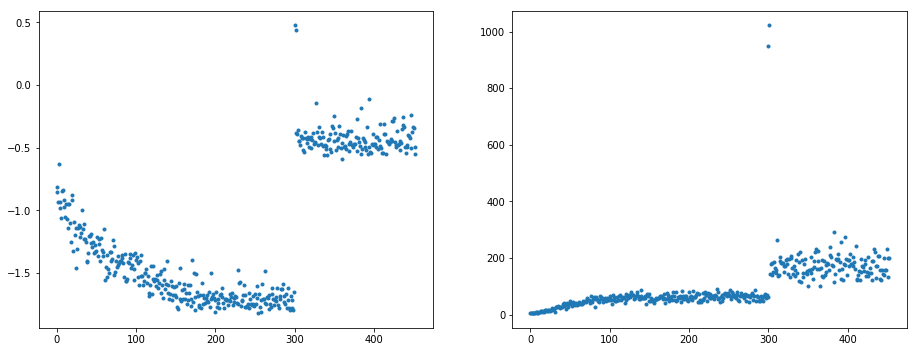

In [214]:
_, Nitr, loss = zip(*hist)
fig = plt.figure(figsize=[40.0/2.57, 15.0/2.57])
fig.clf()
plt.subplot(1,2,1)
plt.plot(loss, '.')
plt.yscale('linear')
plt.subplot(1,2,2)
plt.plot(Nitr, '.')
plt.yscale('linear')
#plt.close(fig)

Check the norm of each parameters:

In [215]:
for _param in tf.trainable_variables():
    param = sess.run(_param)
    print(_param.name, param.shape, np.linalg.norm(param)**2)

dense/kernel:0 (6, 20) 16.81883321423902
dense/bias:0 (20,) 0.10332594165254338
dense_1/kernel:0 (20, 40) 34.05196116075081
dense_1/bias:0 (40,) 0.1169611105963817
dense_2/kernel:0 (40, 20) 13.446536198484921
dense_2/bias:0 (20,) 0.03929519132306325
dense_3/kernel:0 (20, 3) 2.9907082205018156
dense_3/bias:0 (3,) 0.002678219872476864


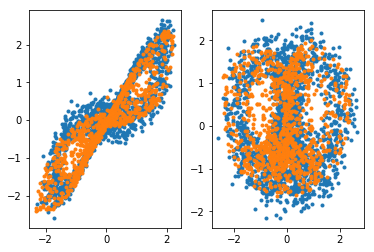

In [231]:
#Z = z_generator(2**10)
P1 = np.random.rand(2**10) * np.pi * 2 * 1
P2 = np.random.rand(2**10) * np.pi * 2 * 1
P3 = np.random.rand(2**10) * np.pi * 2 * 1
Z = np.stack([np.cos(P1), np.sin(P1), np.cos(P2), np.sin(P2), np.cos(P3), np.sin(P3)], axis=1)

X = sess.run(_X, feed_dict={_Z: Z, _is_training: False})
plt.figure()
plt.clf()
plt.subplot(1,2,1)
plt.plot(x_train[:, 0], x_train[:, 1], '.')
plt.plot(X[:, 0], X[:, 1], '.')
plt.subplot(1,2,2)
plt.plot(x_train[:, 1], x_train[:, 2], '.')
plt.plot(X[:, 1], X[:, 2], '.')

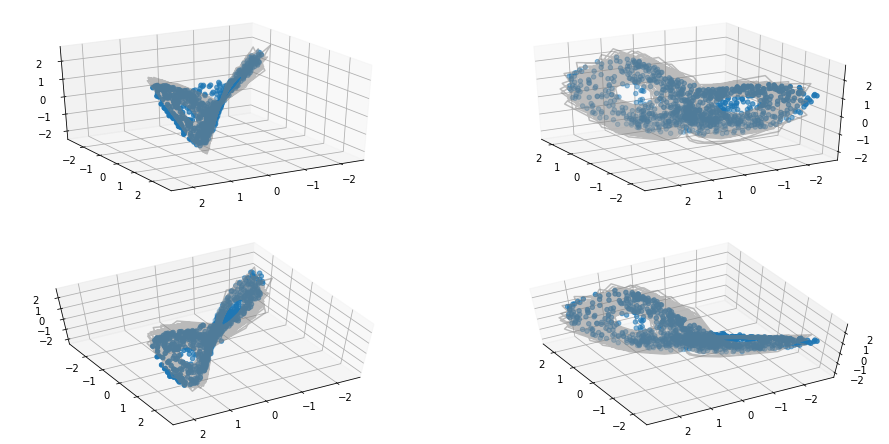

In [232]:
fig = plt.figure(figsize=[40/2.57, 20/2.57])
ang = (30, 60)

fig.clf()
ax = fig.add_subplot(221, projection='3d')
ax.plot(x_train[:,0], x_train[:, 1], x_train[:, 2], '-', color='gray', alpha =.5)
ax.scatter3D(X[:,0], X[:, 1], X[:, 2])
ax.view_init(*ang)
ax = fig.add_subplot(222, projection='3d')
ax.plot(x_train[:,0], x_train[:, 1], x_train[:, 2], '-', color='gray', alpha =.5)
ax.scatter3D(X[:,0], X[:, 1], X[:, 2])
ax.view_init(ang[0], ang[1] + 90)
ax = fig.add_subplot(223, projection='3d')
ax.plot(x_train[:,0], x_train[:, 1], x_train[:, 2], '-', color='gray', alpha =.5)
ax.scatter3D(X[:,0], X[:, 1], X[:, 2])
ax.view_init(ang[0]+30, ang[1])
ax = fig.add_subplot(224, projection='3d')
ax.plot(x_train[:,0], x_train[:, 1], x_train[:, 2], '-', color='gray', alpha =.5)
ax.scatter3D(X[:,0], X[:, 1], X[:, 2])
ax.view_init(ang[0]+30, ang[1] + 90)